In [87]:
import utils
import pandas as pd
from recommender import Customer, recommend_products
import torch
from model_class import SpendingsPredictor, SpendingsPredictor3, SpendingsPredictor4
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import random

In [34]:
laptops = pd.read_csv("laptops_data.csv")
keyboards = pd.read_csv("keyboards_data.csv")

In [3]:
gender = ["Male", "Female"]
age = [i for i in range(20, 80)]
profession = ['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist', 'Executive', 'Doctor', 'Homemaker', 'Marketing']
work_exp = [i for i in range(0, 20)]
family = [i for i in range(0, 10)]
products_bought = [i for i in range(1, 30)]
married = ["Yes", "No"]
graduated = ["Yes", "No"]
category = ["Cat_1","Cat_2","Cat_3","Cat_4","Cat_5","Cat_6"]

In [79]:
class CustomerRecommenadation:
    def __init__(self, customer, laptops, keyboards, args):
        self.customer = customer
        self.laptops = laptops
        self.keyboards = keyboards
        self.keyboard_mean = keyboards["Price"].mean()
        self.laptop_mean = laptops["Price"].mean()
        self.args = args

    def __repr__(self) -> str:
        return f"{self.keyboard_mean}, {self.laptop_mean}, args: {self.args}"
    def __str__(self) -> str:
        return f"{self.keyboard_mean}, {self.laptop_mean}, args: {self.args}"


In [99]:
def visualize_predictions(model_path):
    model = torch.load(model_path)

    customer_recommendation = []
    model_outputs = []
    for _ in range(10000):
        occupation = random.choice(profession)
        args = [
            random.choice(gender),
            random.choice(age),
            occupation,
            random.choice(work_exp),
            random.choice(family),
            random.choice(products_bought),
            random.choice(married),
            random.choice(graduated),
            random.choice(category)]
        args_copy = args.copy()
        mapped_customer = utils.map_customer(args)
        model_output = model(mapped_customer)
        model_outputs.append(model_output)
        values = model_output.detach().numpy()
        customer = Customer(values[0, 0], values[0, 2], occupation, values[0, 1])
        products = recommend_products(customer, laptops, keyboards)
        laptop = products[0].loc[:, ["Laptop", "Price", "Discounted"]]
        keyboard = products[1].loc[:, ["Name", "Price", "Discounted"]]

        customer_recommendation.append(CustomerRecommenadation(customer, laptop, keyboard, args_copy))

    customer_recommendation = np.array(customer_recommendation)
    customer_recommendation = sorted(customer_recommendation, key=lambda x: (x.laptop_mean, x.keyboard_mean))

    keyboard_means = np.array([c.keyboard_mean for c in customer_recommendation])
    laptop_means = np.array([c.laptop_mean for c in customer_recommendation])

    keyboard_means = keyboard_means.reshape(-1, 1)  # Reshape to a column vector
    laptop_means = laptop_means.reshape(-1, 1)  # Reshape to a column vector

    # Fit linear regression model
    regression_model = LinearRegression()
    regression_model.fit(keyboard_means, laptop_means)

    # Predict values for the regression line
    x_values = np.linspace(min(keyboard_means), max(keyboard_means), 100).reshape(-1, 1)
    y_values = regression_model.predict(x_values)

    residuals = laptop_means - regression_model.predict(keyboard_means)
    std_dev = np.std(residuals)

    in_std_dev = np.sum(np.abs(residuals) <= std_dev)

    # Calculate the percentage of values within the standard deviation
    percentage = (in_std_dev / len(residuals)) * 100

    fig, ax = plt.subplots(1,2, figsize=(15,4))
    ax[0].scatter(keyboard_means, laptop_means, s=10)
    ax[0].plot(x_values, y_values, color='red', linestyle='-', linewidth=2)
    ax[0].fill_between(x_values.ravel(), (y_values-2*std_dev).ravel(), (y_values+2*std_dev).ravel(), color="green", alpha=0.1)
    sm.qqplot(residuals.flatten(), line='45', ax=ax[1])
    ax[1].set_title('QQ Plot of Residuals')
    plt.show()

    return percentage, customer_recommendation[10], customer_recommendation[5000], customer_recommendation[9990], model_outputs


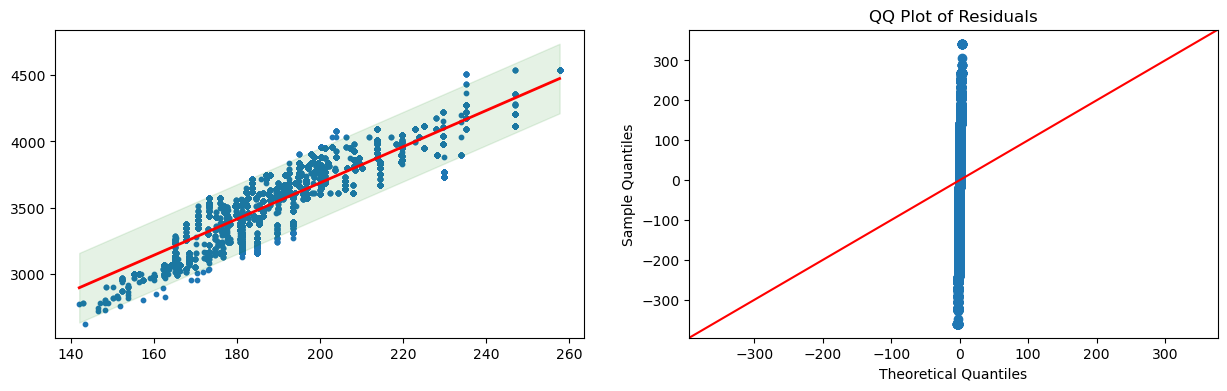

In [100]:
p, c1, c2, c3, mo = visualize_predictions("spendings_predictor.pt")

In [101]:
print(c1)
print(c2)
print(c3)


148.89818181818183, 2783.445652173913, args: ['Female', 29, 'Artist', 7, 6, 1, 'No', 'Yes', 'Cat_4']
196.23, 3643.174285714286, args: ['Male', 79, 'Doctor', 8, 1, 13, 'Yes', 'No', 'Cat_3']
257.6666666666667, 4541.158571428571, args: ['Male', 76, 'Homemaker', 18, 7, 16, 'Yes', 'No', 'Cat_2']


In [112]:
mean1 = np.array([m.detach().numpy()[0,1] for m in mo]).min()
mean1

0.44894782

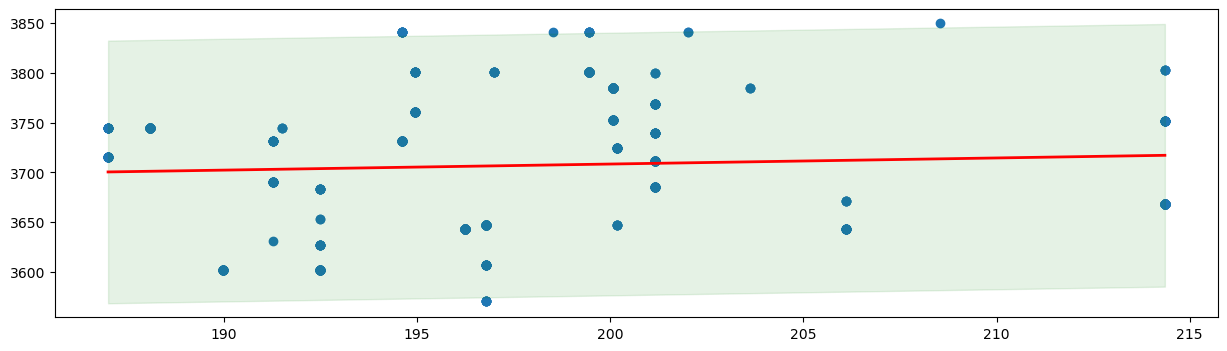

64.8

In [49]:
#visualize_predictions("spendings_predictor3.pt")

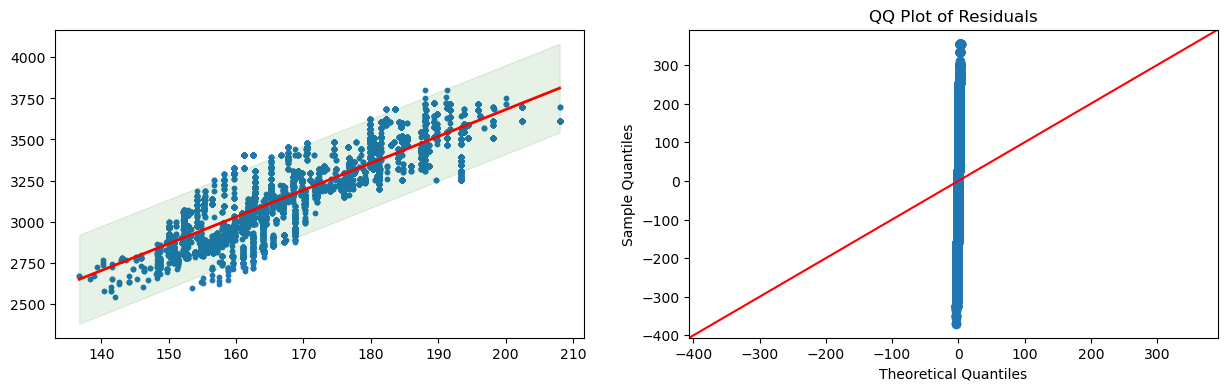

72.22

In [62]:
visualize_predictions("spendings_predictor4.pt")